In [131]:
# ML related
from time import sleep, thread_time
import glob
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import numpy as np

# Model training
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# system requirements
import os, sys


# Load dataset
path = "/home/abuyusif01/dev/dtss/dt/fp/src/clean_logs/"
all_files = glob.glob(os.path.join(path, "*_label.csv"))
df = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)

# Drop columns
df = df.drop(columns=["timestamp"]) # drop timestamp column
class_x = df.drop(columns=["class"])
class_y = df["class"]

# Split dataset into training set and test set
x_train, x_test, y_train, y_test = train_test_split(
    class_x,
    class_y,
    test_size=0.3, # 70% training and 30% test
    random_state=1,
)

df_analysis = pd.concat([x_test, y_test], axis=1) # this print the test data with the class
print(df["class"].value_counts())

Normal                  1824
Command Injection TL     253
Command Injection TH      62
Name: class, dtype: int64


In [132]:
# 1. RandomForest Model Test Results
import pickle
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier

random_forest = OneVsRestClassifier(RandomForestClassifier(random_state=1))

random_forest.fit(x_train, y_train)


OneVsRestClassifier(estimator=RandomForestClassifier(random_state=1))

In [133]:
# 2. GB Model Test Results

from sklearn.ensemble import GradientBoostingClassifier

gb = OneVsRestClassifier(
    GradientBoostingClassifier(
        random_state=1,
        n_estimators=100,
        max_depth=10,
    )
)
gb.fit(x_train, y_train)


OneVsRestClassifier(estimator=GradientBoostingClassifier(max_depth=10,
                                                         random_state=1))

In [134]:
# Logistic Regression Model Test Results
from sklearn.linear_model import LogisticRegression

logistic = OneVsRestClassifier(
    LogisticRegression(
        random_state=1,
        max_iter=10000,
        solver="lbfgs",
    )
)
logistic.fit(x_train, y_train)


OneVsRestClassifier(estimator=LogisticRegression(max_iter=10000,
                                                 random_state=1))

In [135]:
# Naive Bayes Model Test Results
from sklearn.naive_bayes import GaussianNB

naive_bayes = OneVsRestClassifier(
    GaussianNB()
)
naive_bayes.fit(x_train, y_train)


OneVsRestClassifier(estimator=GaussianNB())

In [136]:
# 3. Stacking Model Test Results
# change final_estimator to minimum 2 models

from sklearn.ensemble import StackingClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.neural_network import MLPClassifier

stacking = OneVsRestClassifier(
    StackingClassifier(
        estimators=[
            ("rf", random_forest),
            ("gb", gb),
            ("logistic", logistic),
            ("naive_bayes", naive_bayes),
        ],
        final_estimator=MLPClassifier(
            random_state=1,
            max_iter=10000,
            hidden_layer_sizes=(100, 100),
            solver="lbfgs",
        ),
    )
)
stacking.fit(x_train, y_train)


OneVsRestClassifier(estimator=StackingClassifier(estimators=[('rf',
                                                              OneVsRestClassifier(estimator=RandomForestClassifier(random_state=1))),
                                                             ('gb',
                                                              OneVsRestClassifier(estimator=GradientBoostingClassifier(max_depth=10,
                                                                                                                       random_state=1))),
                                                             ('logistic',
                                                              OneVsRestClassifier(estimator=LogisticRegression(max_iter=10000,
                                                                                                               random_state=1))),
                                                             ('naive_bayes',
                                                              OneVsRestClassifier(estimator=GaussianNB()))],
                                                 final_estimator=MLPClassifier(hidden_layer_sizes=(100,
                                                                                                   100),
                                                                               max_iter=10000,
                                                                               random_state=1,
                                                                               solver='lbfgs')))


        Model: rf 
        Dataset size: 2139
        Accuracy: 1.000000
        Precision: 1.000000
        Recall: 1.000000
        F1: 1.000000
        

        Model: naive_bayes 
        Dataset size: 2139
        Accuracy: 0.691589
        Precision: 0.538965
        Recall: 0.822129
        F1: 0.549592
        

        Model: stacking 
        Dataset size: 2139
        Accuracy: 1.000000
        Precision: 1.000000
        Recall: 1.000000
        F1: 1.000000
        

        Model: logistic 
        Dataset size: 2139
        Accuracy: 0.940810
        Precision: 0.616131
        Recall: 0.603321
        F1: 0.913438
        

        Model: gb 
        Dataset size: 2139
        Accuracy: 1.000000
        Precision: 1.000000
        Recall: 1.000000
        F1: 1.000000
        


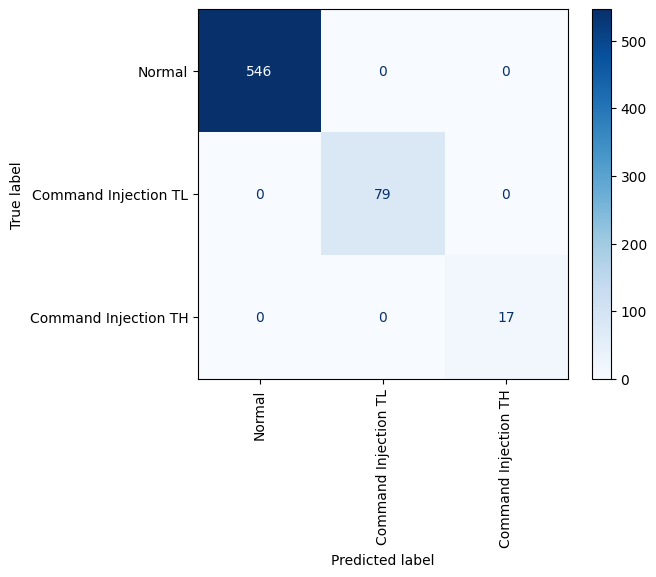

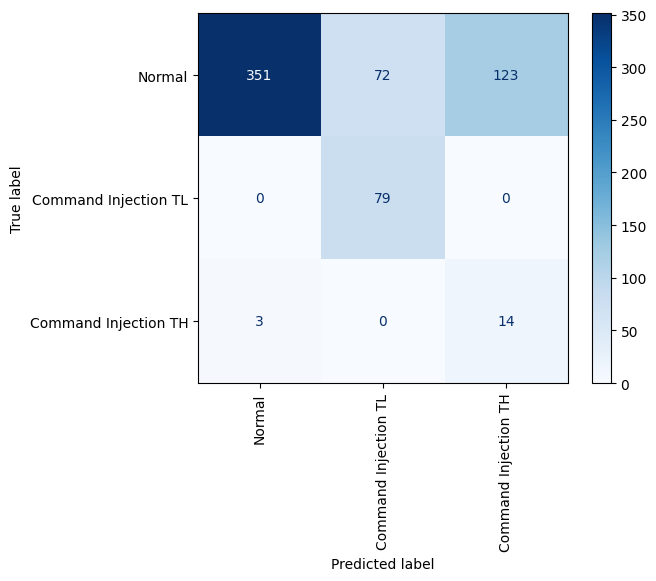

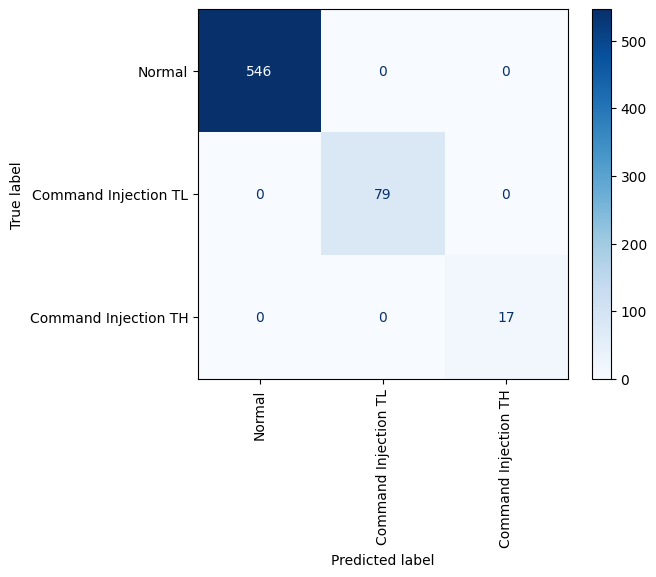

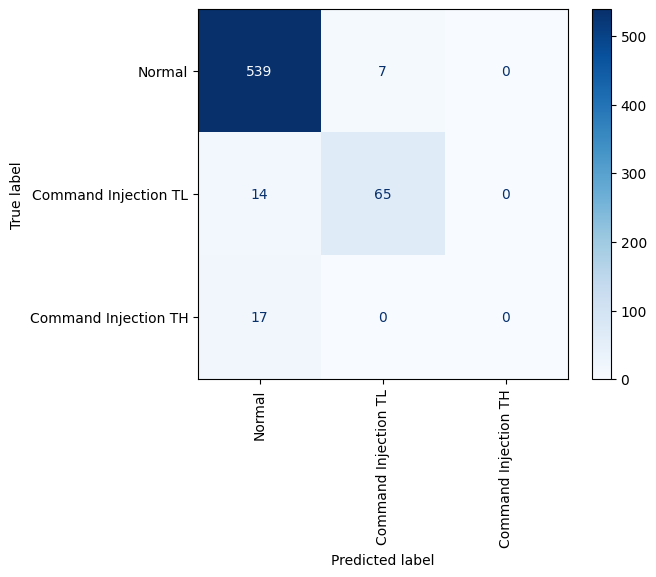

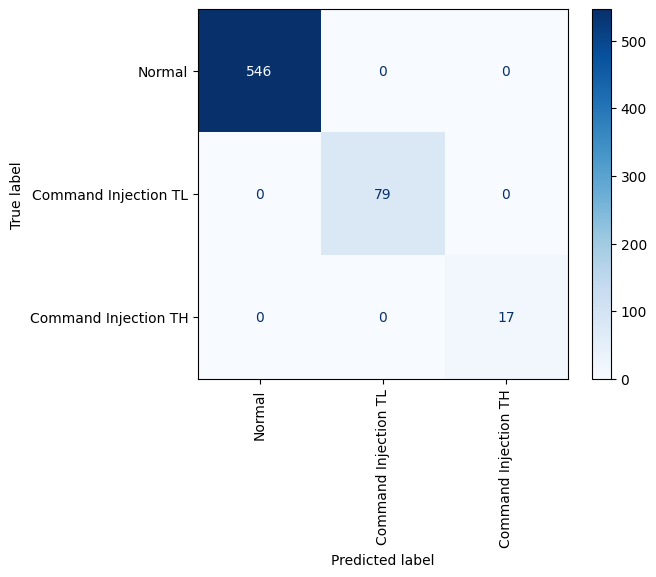

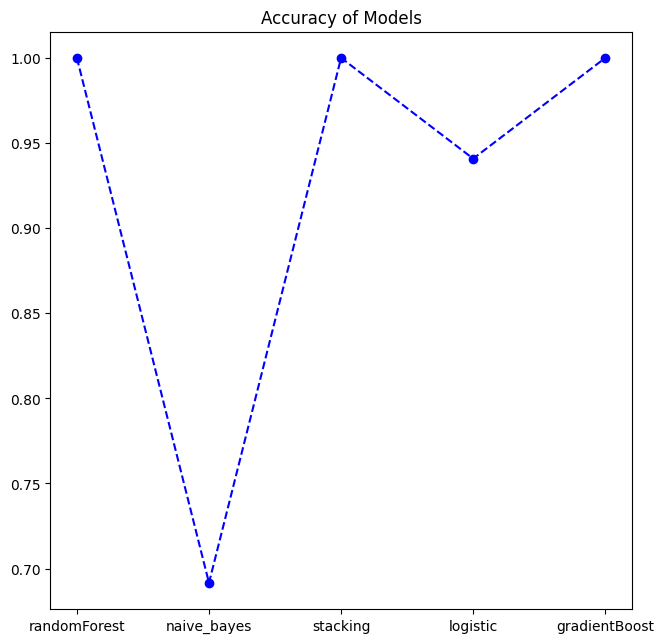

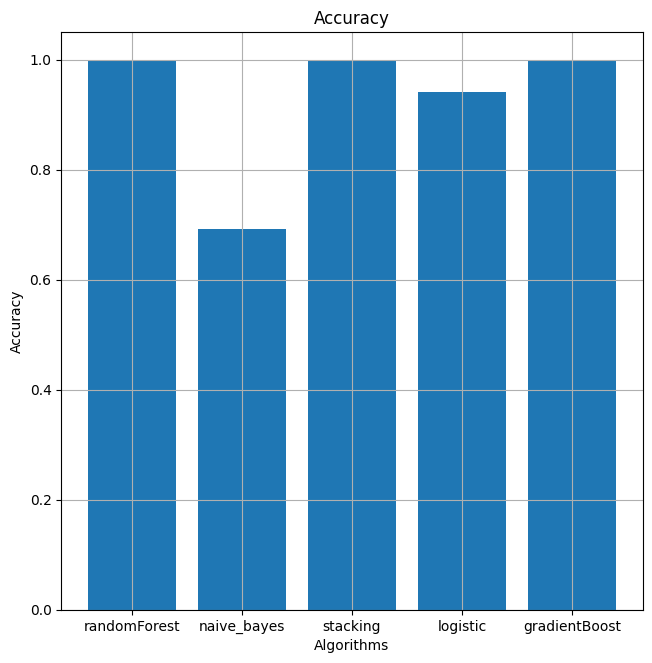

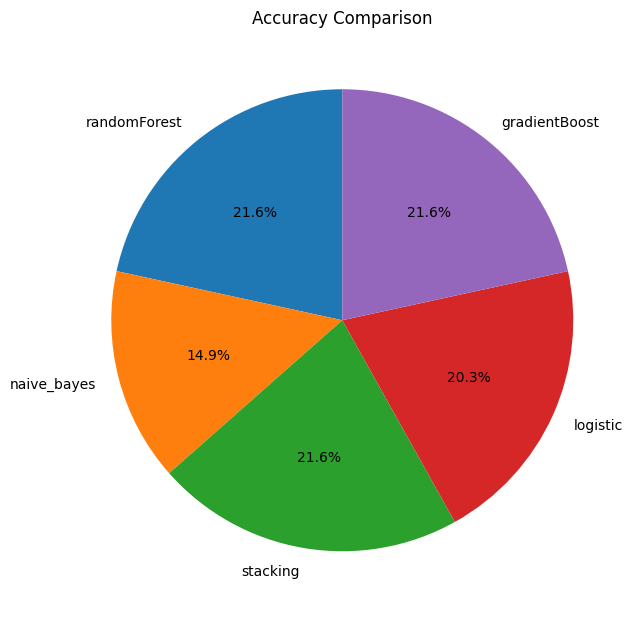

In [137]:
import time, warnings
from turtle import color, title

import pickle  # dump model
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

FIG_SIZE = 7.5


def plot_confusion_matrix(y_test, y_pred, title, labels, color, normalize=False):
    if normalize == False:
        ConfusionMatrixDisplay.from_predictions(
            y_test,
            y_pred,
            labels=labels,
            cmap=color,
            xticks_rotation="vertical",
        )

        return
    ConfusionMatrixDisplay.from_predictions(
        y_test,
        y_pred,
        labels=labels,
        cmap=color,
        normalize="true",
        xticks_rotation="vertical",
    )
    return
    # cm.plot()


models = []
models.append(("rf", random_forest))
models.append(("naive_bayes", naive_bayes))
models.append(("stacking", stacking))
models.append(("logistic", logistic))
models.append(("gb", gb))


models_name = [
    "randomForest",
    "naive_bayes",
    "stacking",
    "logistic",
    "gradientBoost",
]
labels = [
    "Normal",
    "Command Injection TL",
    "Command Injection TH",
]

model_test_accuracy = []
model_test_precision = []
model_test_recall = []
model_test_f1 = []


for x, y in models:
    y.fit(x_train, y_train)
    y_pred = y.predict(x_test)
    y_pred_proba = y.predict_proba(x_test)[:, 1]
    accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)
    precision = sklearn.metrics.precision_score(y_test, y_pred, average="macro")
    recall = sklearn.metrics.recall_score(y_test, y_pred, average="macro")
    confusion_matrix = sklearn.metrics.confusion_matrix(y_test, y_pred)
    f1 = sklearn.metrics.f1_score(
        y_test, y_pred, average="macro", labels=np.unique(y_pred)
    )

    # append algorithm overall test results to list
    model_test_accuracy.append(accuracy)
    model_test_precision.append(precision)
    model_test_recall.append(recall)
    model_test_f1.append(f1)
    sklearn.metrics.multilabel_confusion_matrix(y_test, y_pred)

    # dump model
    pickle.dump(y, open("pkl_files/" + x + ".pkl", "wb"))

    print(
        """
        Model: %s 
        Dataset size: %s
        Accuracy: %f
        Precision: %f
        Recall: %f
        F1: %f
        """
        % (
            x,
            len(df),
            accuracy,
            precision,
            recall,
            f1,
        )
    )

    # overall plot_confusion_matrix
    plot_confusion_matrix(
        y_test,
        y_pred,
        x,
        labels,
        plt.cm.Blues,
    )

# plot dash graph
fig, axes = plt.subplots(figsize=(FIG_SIZE, FIG_SIZE))
axes.title.set_text("Accuracy of Models")
axes.plot(
    models_name,
    model_test_accuracy,
    label="Accuracy",
    marker="o",
    color="blue",
    linestyle="dashed",
)


# plot histogram
fig, axes = plt.subplots(figsize=(FIG_SIZE, FIG_SIZE))
axes.bar(models_name, model_test_accuracy)
axes.set_title("Accuracy")
axes.set_ylabel("Accuracy")
axes.set_xlabel("Algorithms")
axes.grid(True)
plt.show()


# float a pie chart
fig, axes = plt.subplots(figsize=(FIG_SIZE, FIG_SIZE))
axes.pie(
    model_test_accuracy,
    labels=models_name,
    autopct="%1.1f%%",
    startangle=90,
)
axes.grid(True)
axes.set_title("Accuracy Comparison")
plt.show()


In [153]:
# get all confirm attacks

import glob, pandas as pd
from traceback import print_exception

path = "/home/abuyusif01/dev/dtss/dt/fp/src/clean_logs/"
all_files = glob.glob(os.path.join(path, "*_label.csv"))
df = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)


count = 0

# remove if the file exists
if os.path.exists(file_name):
    os.remove(file_name)


# save to new file if condition is met
with open("anomaly.csv", "w") as f:
    f.write(
        str(list(df.columns)[1:][:-1])
        .replace("[", "")
        .replace("]", "")
        .replace("'", "")
        .replace(" ", ""),
    )
    f.write("\n")

for i in range(0, len(df)):

    if str(df["class"][i]) != "Normal":

        with open("anomaly.csv", "a") as f:
            f.write(
                str(df["tank_liquidlevel"][i])
                + ","
                + str(df["flowlevel"][i])
                + ","
                + str(df["bottle_liquidlevel"][i])
                + ","
                + str(df["motor_status"][i]),
            )
            f.write("\n")

            count += 1

print("total number of atacks from logs: ",count)


total number of atacks from logs:  315


In [164]:
cols = ["tank_liquidlevel", "flowlevel", "bottle_liquidlevel", "motor_status"]


def get_result(
    model_name, tank_liquidlevel, flowlevel, bottle_liquidlevel, motor_status
):
    model = pickle.load(open("pkl_files/" + model_name + ".pkl", "rb"))

    result = model.predict(
        [
            [
                tank_liquidlevel,
                flowlevel,
                bottle_liquidlevel,
                motor_status,
            ]
        ]
    )
    return result


# import csv file

file_name = "anomaly.csv"
count = 0
df = pd.read_csv(file_name)

for i in range(0, len(df)):

    with open("all_test", "a") as f:
        f.write(
            str(
                get_result(
                    "rf",
                    str(df["tank_liquidlevel"][i]),
                    str(df["flowlevel"][i]),
                    str(df["bottle_liquidlevel"][i]),
                    str(df["motor_status"][i]),
                )
            )
            + "\n"
        )

    count += 1

# algorithm that works
"""
1. rf -> works
2. gb -> works
3. logistic
4. nb
5. stacking
"""


print("total number of attacks detected by ml: ", count)
print("total number of attacks undetected by ml: ", count - len(df))


total number of attacks detected by ml:  315
total number of attacks undetected by ml:  0
